# Make and check initial conditions

Ran the model using  MOM branch `dev/gfdl-oct7_2025+PGISfixes`: https://github.com/claireyung/MOM6/releases/tag/CYPGv2 (UPDATE LINK!!!)

Starting from NOAA-GFDL commit:

```
commit 4622d6a0f9fb6f09ba859387a176ff5320054cee (origin/dev/gfdl, origin/HEAD, dev/gfdl-oct7_2025)
Author: Robert Hallberg <Robert.Hallberg@noaa.gov>
Date:   Wed Oct 1 10:48:32 2025 -0400

    +*Fix 3-equation ice-ocean flux iteration (#972)
    
```

Plus cherry picked additional commits to 
1. add hack mode for perfect sigma initialisation
2. add diagnostics for reference interface in PG algorithm
3. Bugfix for melt rate on, velocity sampling distance

```
git cherry-pick 06e8279cf2d0a673da063b8802ecf32e8e7a389e
git cherry-pick d632b4cec6fc501b3fdb546453676014e1149aa0
git cherry-pick a25b1a8586f74776e45cf5628feaf830118f8068
```

To run the model experiments (except ISOMIP ones), you can use `bash run_all.sh`

For ISOMIP models, `cd` into each folder (`MOM6-examples-z`,`MOM6-examples-z-noMWIPG`,`z-ISOMIP-quiet`) and use `mpirun  -host localhost ../../../../build/ocean_only/MOM6 -n 8`(these are slower because they are 3D - take a while on my PC!)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm

from xgcm import Grid

### Define some useful functions/plotting routines

In [18]:
basee = '/Users/claireyung/mom6/MOM6-examples/ocean_only/ISOMIP/seamount-icemount-PGtest-sep25/'
def open_files(label):
    base = basee 
    prog = xr.open_dataset(base + label+'/prog.nc')
    return prog
def open_mom(label):
    base = basee 
    mom = xr.open_dataset(base + label+'/mommean.nc')
    return mom
def open_IC(label):
    base = basee 
    IC = xr.open_dataset(base + label+'/MOM_IC.nc')
    return IC
def plot(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax):
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = grid.interp(prog.e,"x")
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
        dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) 
    xi, yyi = np.meshgrid(xx[yy0,:], yi) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [19]:
def plot_u(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax,ymin = 20): #boudnaries are t cell grid
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = prog.e#grid.interp(prog.e,"x")
    lon = prog.e*0 + prog.xh
    dataplot = variable[:,:,:,1:-1]

    #xx = lon
    #if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
    #    dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    #yy = depth[:,:,yy0,:]
    #z_levels = yy.shape[1]
    #yi = np.linspace(0,5000,z_levels) 
    #xi, yyi = np.meshgrid(xx[yy0,:], y) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
#     print(lon.shape)
#     print(depth.shape)
#     print(dataplot.shape)
    cax = ax.pcolormesh(lon[tt,:,yy0,...],depth[tt,:,yy0,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
        
    try:
        mom = open_mom(label)
        reset_ht = mom.reset_u.isel(Time = 0).isel(yh = yy0)
        height_reset = np.zeros(len(reset_ht.xq))
        for x in np.arange(1,len(reset_ht.xq)-1):
            # find depth
            if (np.max(reset_ht.isel(xq = x).values)==0):
                idx = -1 # using surface
            elif (np.max(reset_ht.isel(xq = x).values)==2):
                idx = -1 # using surface
            else:
                idx = np.argmax(reset_ht.isel(xq = x).values)
                print(idx)
            height_reset[x] = grid.interp(prog.e,"x").isel(Time = 0).isel(yh = yy0).isel(xq = x)[idx+1]

        ax.plot(prog.xq[1:-1], height_reset[1:-1], alpha = 0.5, color = 'yellow', linewidth = 2, zorder = 10)
    except AttributeError:
        print('No magic interface output')

    
    ax.set_ylim(ymin=-ymax,ymax=ymin)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


In [20]:
def plot_t(ax,yy0,tt,variable,varname,vmin1,vmax1,cmap,ymax): #boundaries are u cell grid https://gist.github.com/adcroft/dde8d3fafd77d0caaa5613e64f1d7eff
    prog = open_files(label)
    ocean_static = xr.open_dataset(label +'/ocean_geometry.nc')
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = label
    #IC = open_IC(label)
    depth = grid.interp(prog.e,"x", boundary="extend")
    lon = depth*0 + depth.xq
    dataplot = variable

    #xx = lon
    #if (varname == "uo") or (varname == "PFu") or (varname == "visc_rem_u"): 
    #    dataplot = grid.interp(dataplot,"x")
    levels = np.linspace(vmin1, vmax1, 51)
    #yy = depth[:,:,yy0,:]
    #z_levels = yy.shape[1]
    #yi = np.linspace(0,5000,z_levels) 
    #xi, yyi = np.meshgrid(xx[yy0,:], y) 
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    #cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    #print(lon.shape)
    #print(depth.shape)
    #print(dataplot.shape)
    cax = ax.pcolormesh(lon[tt,:,yy0,...],depth[tt,:,yy0,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    if (varname == "uo"):
        cbar = plt.colorbar(cax, ax = ax, label = " ")
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.yaxis.set_offset_position('right')
        cbar.update_ticks()

    else:
        plt.colorbar(cax, ax = ax, label = varname)
    #plt.colorbar(cax, ax = ax, label = 'u (m/s)')
    
    ## plot interface heights
    i_heights = depth # this is 'Interface Height Relative to Mean Sea Level' interpolated to u
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xq = prog.xq

    for i in range(nz):
        ax.plot(xq,i_heights[i], color = 'k', linewidth = 0.2)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    


# Make quadratic input files

(After linear versions have been run)

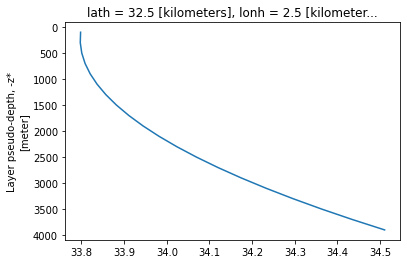

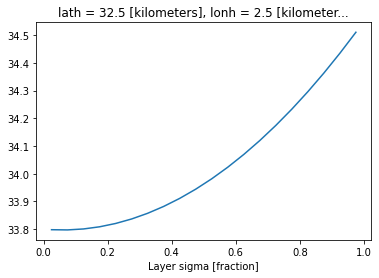

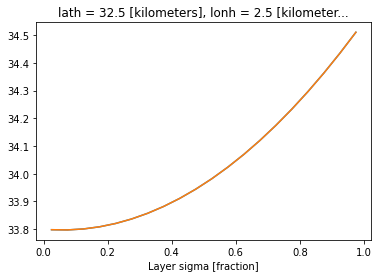

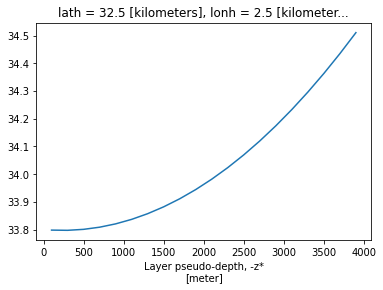

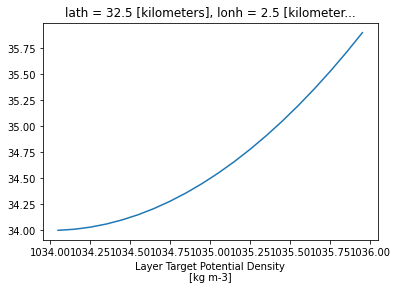

In [7]:
# make quadratic profile
IC = open_IC('seamount-z')
IC_S_COPY = IC.Salt.isel(lath = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2
IC_S_COPY = IC_S_COPY + 0.85*(middle_depth)*(middle_depth-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot(y = 'Layer',yincrease = False)
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time')
ds_ICfile.to_netcdf('INPUT/quadraticSaltseamountz.nc')
plt.show()

# make quadratic profile
IC = open_IC('seamount-sigma')
IC_S_COPY = IC.Salt.isel(lath = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2
IC_S_COPY = IC_S_COPY + 0.85*(middle_depth)*(middle_depth-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time')
ds_ICfile.to_netcdf('INPUT/quadraticSaltseamountsigma.nc')

plt.show()

# make quadratic profile
IC = open_IC('icemount-sigma-LSPR')
IC_S_COPY = IC.Salt#.isel(lath = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 -IC.eta.isel(Interface = 0)
IC_S_COPY = IC_S_COPY + 0.85*(middle_depth)*(middle_depth-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time')
ds_ICfile.to_netcdf('INPUT/quadraticSalticemountsigma.nc')

# make quadratic profile
IC = open_IC('icemount-sigma-LSPR')
IC_S_COPY = IC.Salt.isel(lonh = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 +IC.eta.isel(Interface = 0)
IC_S_COPY = IC_S_COPY + 0.85*(middle_depth.isel(lonh = 0))*(middle_depth.isel(lonh = 0)-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time').isel(lonh = 0, lath = 0)
ds_ICfile.to_netcdf('INPUT/quadraticSalticemountsigma1D.nc')
plt.show()

# make quadratic profile
IC = open_IC('icemount-z-LSPR')
IC_S_COPY = IC.Salt.isel(lonh = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 +IC.eta.isel(Interface = 0)
IC_S_COPY = IC_S_COPY + 0.85*(middle_depth.isel(lonh = 0))*(middle_depth.isel(lonh = 0)-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time').isel(lonh = 0, lath = 0)
ds_ICfile.to_netcdf('INPUT/quadraticSalticemountz1D.nc')
plt.show()
# make quadratic profile
IC = open_IC('icemount-layer-LSPR')
IC_S_COPY = IC.Salt.isel(lonh = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 +IC.eta.isel(Interface = 0)
IC_S_COPY = IC_S_COPY + 2*(middle_depth.isel(lonh = 0))*(middle_depth.isel(lonh = 0)-4000)/4000**2
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time').isel(lonh = 0, lath = 0)
ds_ICfile.to_netcdf('INPUT/quadraticSalticemountlayer1D.nc')

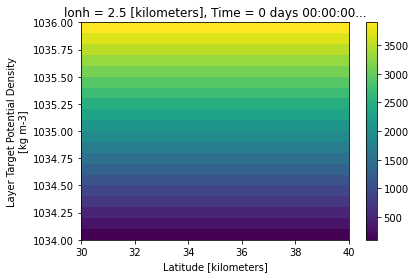

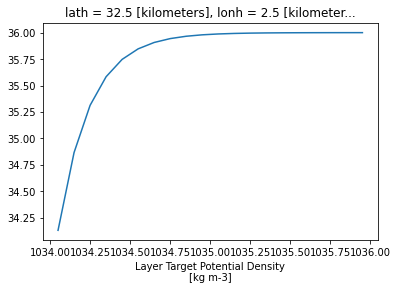

In [8]:
# make exponential profile rhotop+S*(np.exp(-((depth)/z_bot*10))-1)
IC = open_IC('icemount-layer-LSPR')
IC_S_COPY = IC.Salt.isel(lonh = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 +IC.eta.isel(Interface = 0)
middle_depth.isel(lonh=0).plot()
plt.show()
IC_S_COPY = IC_S_COPY*0+33.6 - 2.4*(np.exp(-middle_depth.isel(lonh = 0)/400)-1)
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time').isel(lonh = 0, lath = 0)
ds_ICfile.to_netcdf('INPUT/exponentialSalticemountlayer1D.nc')


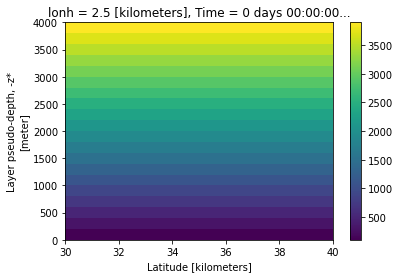

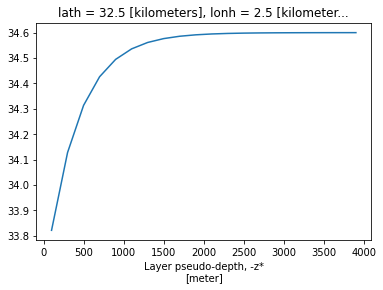

In [9]:
# make exponential profile rhotop+S*(np.exp(-((depth)/z_bot*10))-1)
IC = open_IC('icemount-z-LSPR')
IC_S_COPY = IC.Salt.isel(lonh = 0)+IC.Salt*0
middle_depth = IC.h.cumsum('Layer')-IC.h/2 +IC.eta.isel(Interface = 0)
middle_depth.isel(lonh=0).plot()
plt.show()
IC_S_COPY = IC_S_COPY*0+33.6 - 1*(np.exp(-middle_depth.isel(lonh = 0)/400)-1)
IC_S_COPY.isel(Time = 0, lath = 0, lonh = 0).plot()
IC_S_COPY = IC_S_COPY.isel(Time = 0).rename('SALT')
ds_ICfile = xr.merge([IC_S_COPY.transpose("Layer","lath","lonh"), 
                      IC.Temp.isel(Time = 0).rename('PTEMP')]).drop('Time').isel(lonh = 0, lath = 0)
ds_ICfile.to_netcdf('INPUT/exponentialSalticemountz1D.nc')


# Plot actual vs theoretical salinity

Difference should be zero if correctly initialised

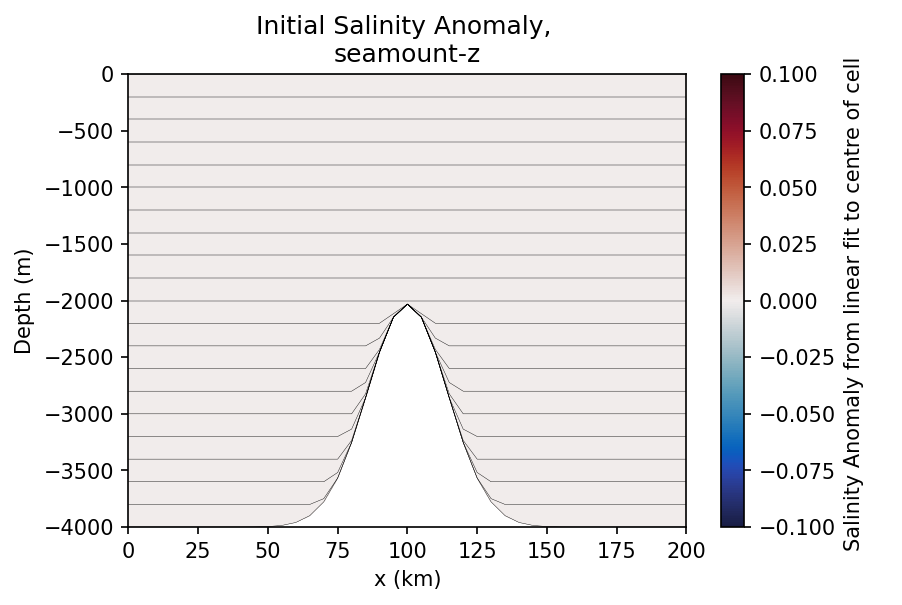

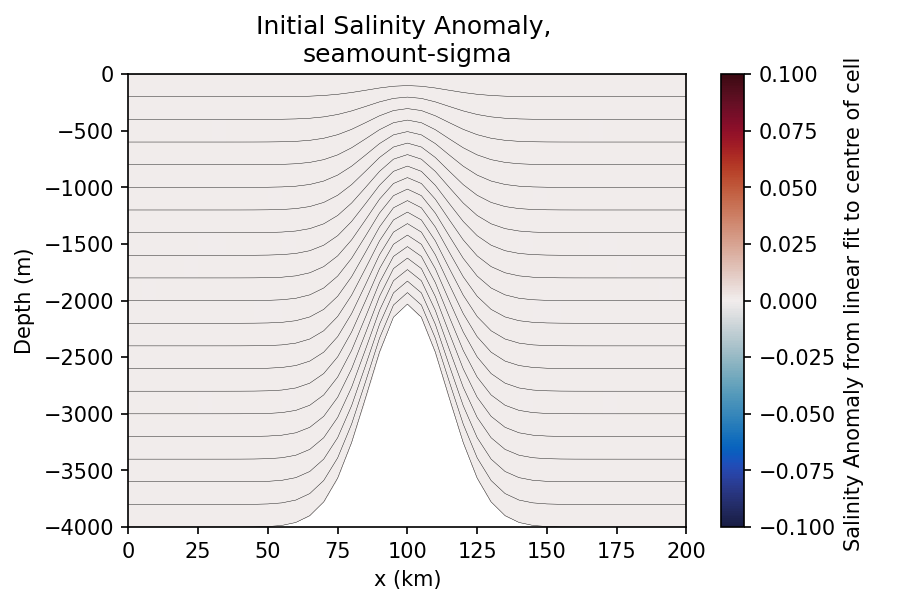

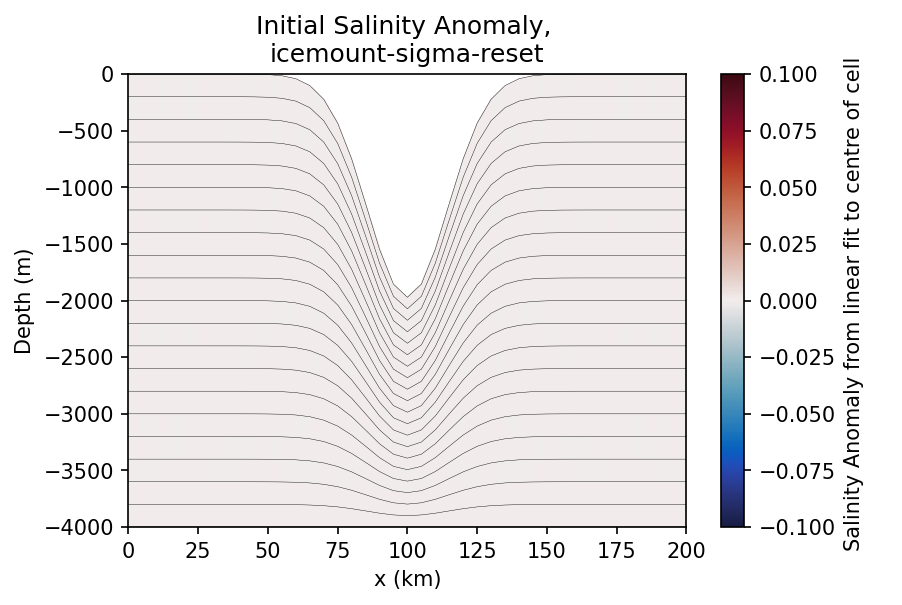

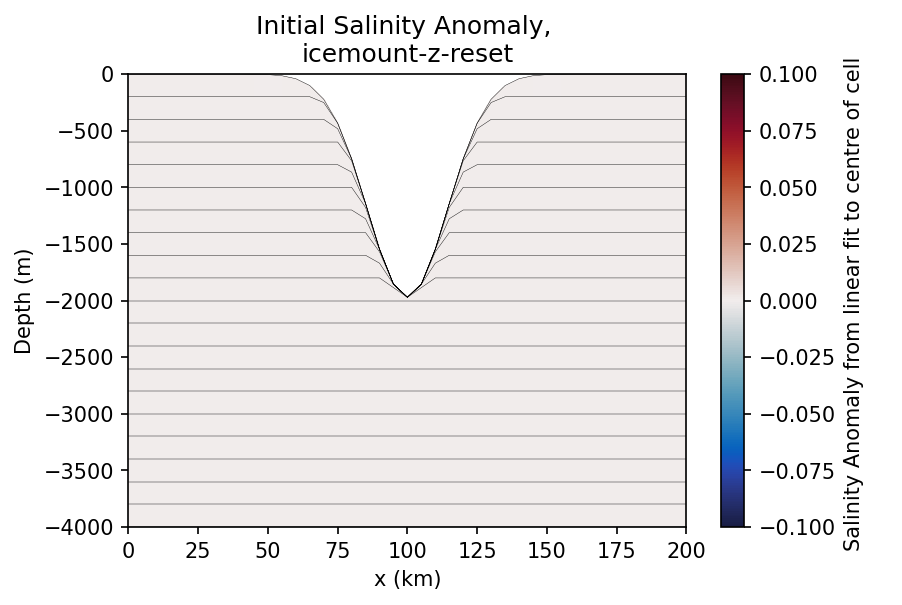

In [16]:
# linear

for label in ['seamount-z','seamount-sigma','icemount-sigma-reset',
             'icemount-z-reset']:

    fig, axes = plt.subplots(dpi = 150)
    IC = open_IC(label)
    time = 0
    x = 0
    ymax = 4000
    
    ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) \
    + 33.8 #+ ((IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2+4000))/4000**2*0.85
    plot_t(axes,x,time,IC.Salt-ideal_salt,"Salinity Anomaly from linear fit to centre of cell \n",-1e-1,1e-1,cm.cm.balance,ymax)
    axes.set_title('Initial Salinity Anomaly, \n'+label)
    plt.show()


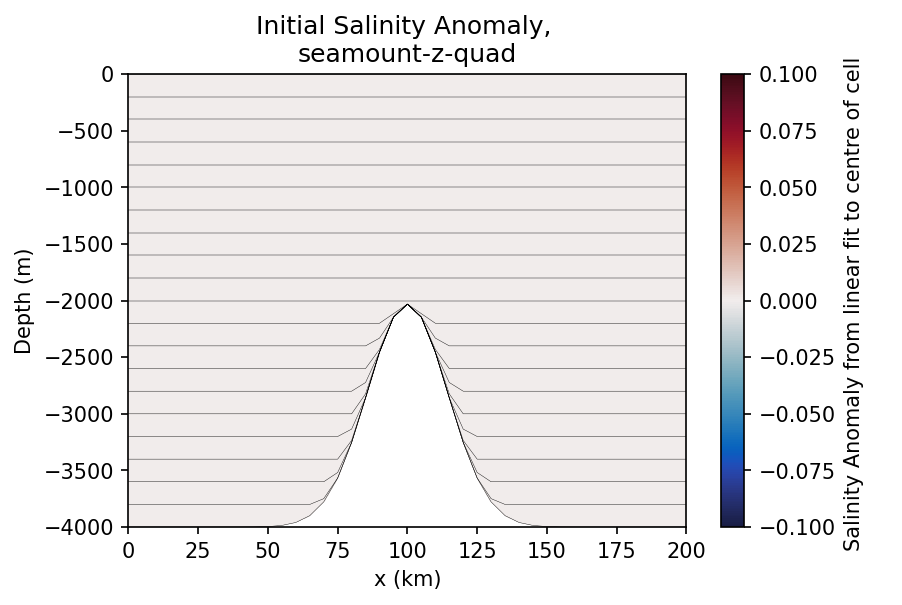

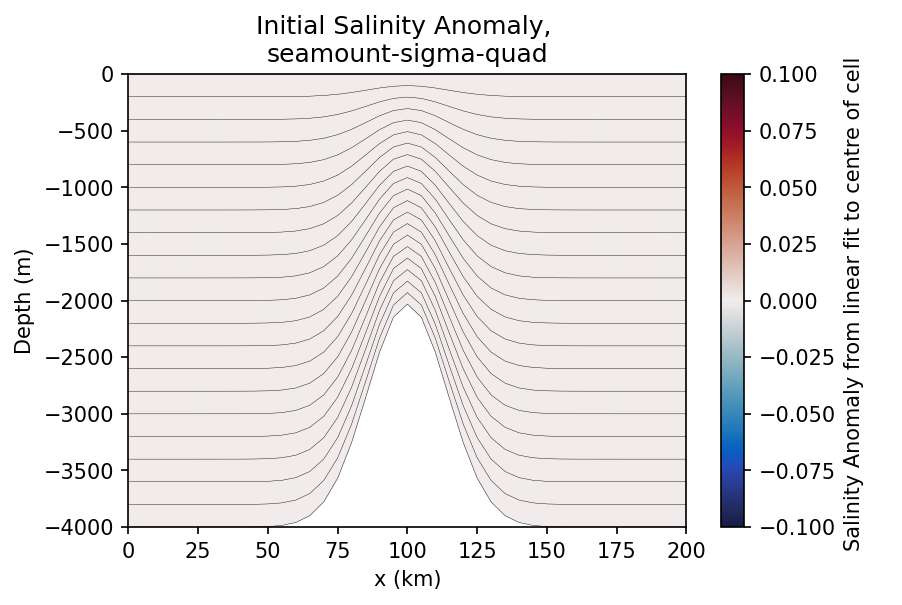

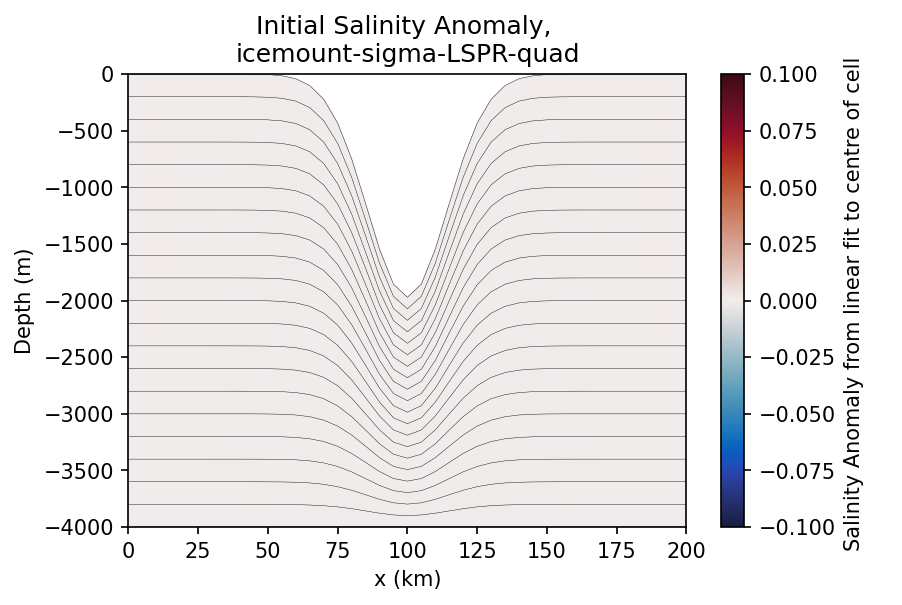

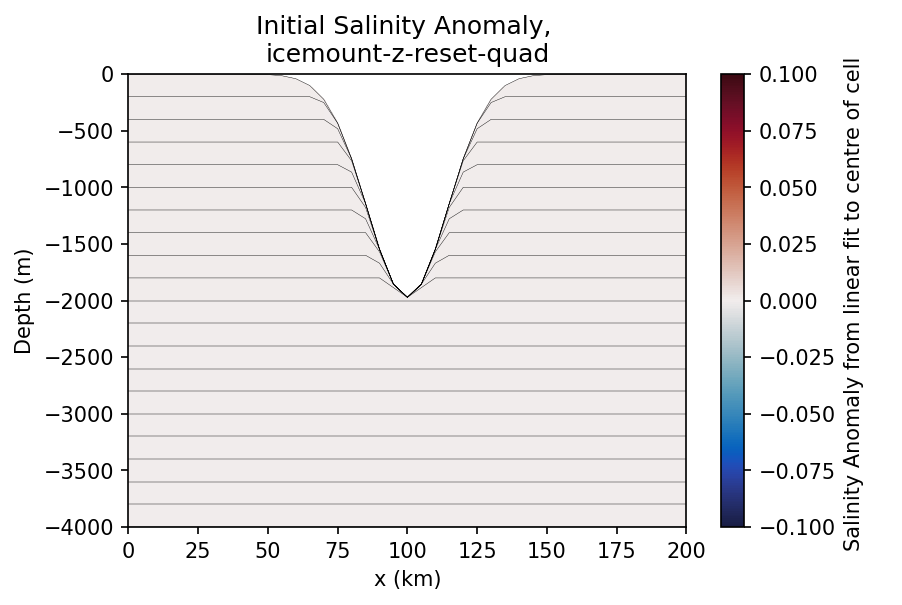

In [15]:
# quadratic

for label in ['seamount-z-quad','seamount-sigma-quad','icemount-sigma-LSPR-quad',
             'icemount-z-reset-quad']:

    fig, axes = plt.subplots(dpi = 150)
    IC = open_IC(label)
    time = 0
    x = 0
    ymax = 4000
    
    ideal_salt = xr.zeros_like(IC.Salt) + (IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(34.55-33.8)/(-4000) \
    + 33.8 + ((IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2)*(IC.eta.isel(Interface = 0)-IC.h.cumsum('Layer')+IC.h/2+4000))/4000**2*0.85
    plot_t(axes,x,time,IC.Salt-ideal_salt,"Salinity Anomaly from theoretical fit to centre of cell \n",-1e-1,1e-1,cm.cm.balance,ymax)
    axes.set_title('Initial Salinity Anomaly, \n'+label)
    plt.show()
